# Reconstructing temperature + precipitation

In [4]:
%load_ext autoreload
%autoreload 2

import cfr
print(cfr.__version__)
import os
os.chdir('/glade/u/home/fengzhu/Github/cfr/docsrc/notebooks')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
2024.8.1


## Load the PAGES2k database

Here we pick some TRW data for illustration purposes.

Slicing ProxyRecord: 100%|██████████| 19/19 [00:00<00:00, 2557.58it/s]


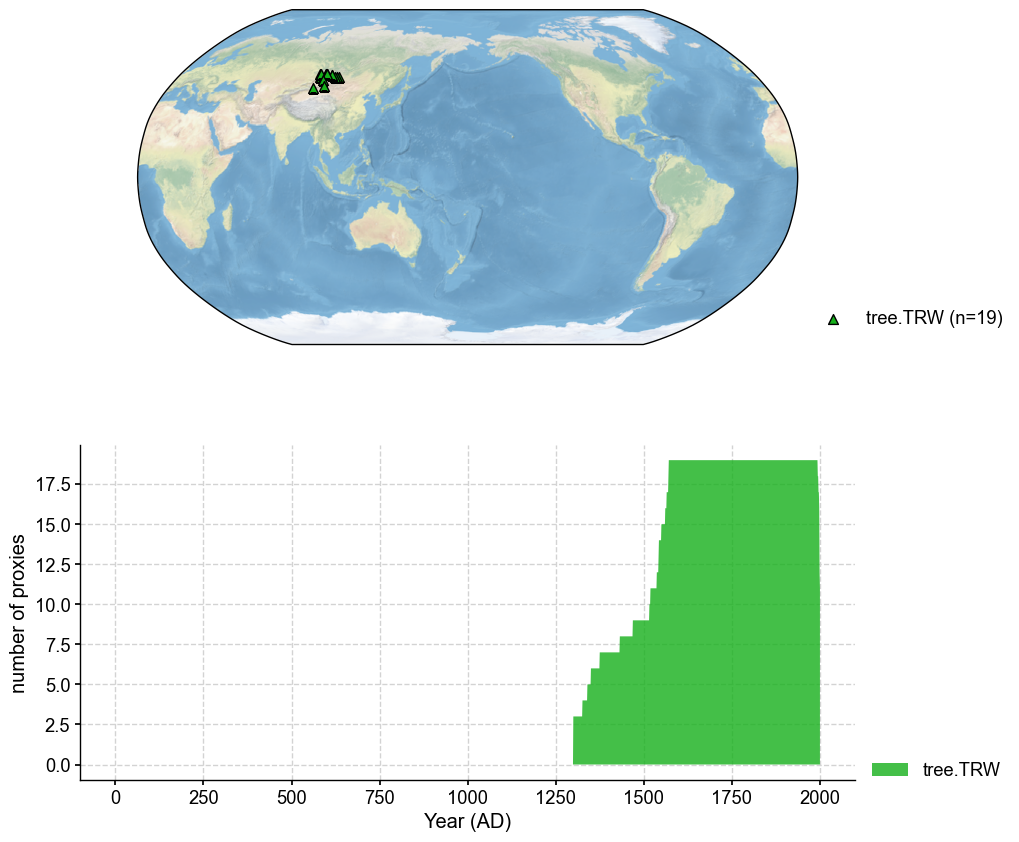

In [2]:
job = cfr.ReconJob()
job.load_proxydb('PAGES2kv2')
job.filter_proxydb(by='ptype', keys=['tree.TRW'])
job.filter_proxydb(by='loc-square', keys=[40, 50, 80, 100])
job.slice_proxydb(timespan=[1300, 2000])
fig, ax = job.proxydb.plot(plot_count=True)

## Load the gridded climate data

### Load the model prior

In [5]:
job.load_clim(
    tag='prior',
    path_dict={
        'tas': 'iCESM_past1000historical/tas',
        'pr': 'iCESM_past1000historical/pr',
    },
    anom_period=(1951, 1980),
)

>>> The target file seems existed at: ./data/tas_sfc_Amon_iCESM_past1000historical_085001-200512.nc . Loading from it instead of downloading ...
>>> The target file seems existed at: ./data/pr_sfc_Amon_iCESM_past1000historical_085001-200512.nc . Loading from it instead of downloading ...


### Load the instrumental observations

In [6]:
job.load_clim(
    tag='obs',
    path_dict={
        'tas': 'gistemp1200_GHCNv4_ERSSTv5',
        'pr': 'GPCCv2020',
    },
    rename_dict={
        'tas': 'tempanomaly',
        'pr': 'precip',
    },
    anom_period=(1982, 2020),
)

>>> The target file seems existed at: ./data/gistemp1200_GHCNv4_ERSSTv5.nc.gz . Loading from it instead of downloading ...
>>> The target file seems existed at: ./data/precip.monitor.mon.total.1x1.v2020.nc . Loading from it instead of downloading ...


## Proxy system modeling

### Calibrating the proxy system models

In [8]:
ptype_psm_dict = {
    'tree.TRW': 'Bilinear',
}

ptype_season_dict = {
    'tree.TRW': [3, 4, 5, 6, 7, 8],
}

ptype_clim_dict = {
    'tree.TRW': ['tas', 'pr'],
}

job.calib_psms(
    ptype_psm_dict=ptype_psm_dict,
    ptype_season_dict=ptype_season_dict,
    ptype_clim_dict=ptype_clim_dict,
    calib_period=(1982, 2020),
    nobs_lb=15,
    verbose=True,
)

>>> job.configs["ptype_psm_dict"] = {'tree.TRW': 'Bilinear'}
>>> job.configs["ptype_season_dict"] = {'tree.TRW': [3, 4, 5, 6, 7, 8]}
>>> job.configs["ptype_clim_dict"] = {'tree.TRW': ['tas', 'pr']}
>>> job.configs["psm_calib_period"] = (1982, 2020)


Calibrating the PSMs: 100%|██████████| 19/19 [00:00<00:00, 19.01it/s]

The number of overlapped data points is 14 < 15. Skipping ...
The number of overlapped data points is 12 < 15. Skipping ...
>>> PSM for Asi_159 failed to be calibrated.
>>> PSM for Asi_074 failed to be calibrated.
>>> 17 records tagged "calibrated" with ProxyRecord.psm created


### Forwarding the proxy system models

In [9]:
job.forward_psms()

Forwarding the PSMs: 100%|██████████| 17/17 [00:06<00:00,  2.72it/s]


## Annualizing, regridding, and cropping the prior field

In [10]:
job.annualize_clim(tag='prior', verbose=True)
job.regrid_clim(tag='prior', nlat=42, nlon=63, verbose=True)
job.crop_clim(tag='prior', lat_min=30, lat_max=60, lon_min=70, lon_max=110, verbose=True)

>>> job.configs["prior_annualize_months"] = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
>>> Processing tas ...
>>> Processing pr ...
>>> job.prior updated
>>> job.configs["prior_regrid_nlat"] = 42
>>> job.configs["prior_regrid_nlon"] = 63
>>> Processing tas ...
>>> Processing pr ...
>>> job.configs["prior_lat_min"] = 30
>>> job.configs["prior_lat_max"] = 60
>>> job.configs["prior_lon_min"] = 70
>>> job.configs["prior_lon_max"] = 110
>>> Processing tas ...
>>> Processing pr ...


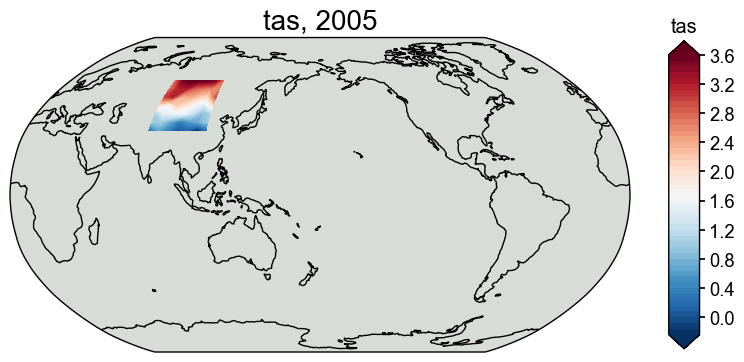

In [11]:
fig, ax = job.prior['tas'][-1].plot()
# fig, ax = job.prior['pr'][-1].plot()

## Run the DA solver

In [21]:
job.run_da_mc(
    save_dirpath='./recons/lmr-recon-pr',
    recon_seeds=list(range(1, 11)),
    recon_vars=['tas', 'pr'],
    verbose=True,
)

>>> job.configs["recon_vars"] = ['tas', 'pr']
>>> job.configs["recon_seeds"] = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
>>> job.configs["save_dirpath"] = ./recons/lmr-recon-pr
>>> seed: 1 | max: 10


KF updating: 100%|██████████| 2001/2001 [00:02<00:00, 947.15it/s]


>>> Reconstructed fields saved to: ./recons/lmr-recon-pr/job_r01_recon.nc
>>> seed: 2 | max: 10


KF updating: 100%|██████████| 2001/2001 [00:02<00:00, 731.85it/s] 


>>> Reconstructed fields saved to: ./recons/lmr-recon-pr/job_r02_recon.nc
>>> seed: 3 | max: 10


KF updating: 100%|██████████| 2001/2001 [00:02<00:00, 739.55it/s] 


>>> Reconstructed fields saved to: ./recons/lmr-recon-pr/job_r03_recon.nc
>>> seed: 4 | max: 10


KF updating: 100%|██████████| 2001/2001 [00:02<00:00, 702.02it/s] 


>>> Reconstructed fields saved to: ./recons/lmr-recon-pr/job_r04_recon.nc
>>> seed: 5 | max: 10


KF updating: 100%|██████████| 2001/2001 [00:02<00:00, 683.02it/s] 


>>> Reconstructed fields saved to: ./recons/lmr-recon-pr/job_r05_recon.nc
>>> seed: 6 | max: 10


KF updating: 100%|██████████| 2001/2001 [00:02<00:00, 686.40it/s] 


>>> Reconstructed fields saved to: ./recons/lmr-recon-pr/job_r06_recon.nc
>>> seed: 7 | max: 10


KF updating: 100%|██████████| 2001/2001 [00:02<00:00, 676.06it/s] 


>>> Reconstructed fields saved to: ./recons/lmr-recon-pr/job_r07_recon.nc
>>> seed: 8 | max: 10


KF updating: 100%|██████████| 2001/2001 [00:02<00:00, 680.97it/s] 


>>> Reconstructed fields saved to: ./recons/lmr-recon-pr/job_r08_recon.nc
>>> seed: 9 | max: 10


KF updating: 100%|██████████| 2001/2001 [00:02<00:00, 685.33it/s] 


>>> Reconstructed fields saved to: ./recons/lmr-recon-pr/job_r09_recon.nc
>>> seed: 10 | max: 10


KF updating: 100%|██████████| 2001/2001 [00:02<00:00, 685.08it/s] 


>>> Reconstructed fields saved to: ./recons/lmr-recon-pr/job_r10_recon.nc
>>> DONE! Total time spent: 0.66 mins.


## Validate the reconstruction

In [22]:
res = cfr.ReconRes('./recons/lmr-recon-pr')
res.load(['tas', 'pr'], verbose=True)

>>> ReconRes.recons["tas"] created
>>> ReconRes.da["tas"] created
>>> ReconRes.recons["pr"] created
>>> ReconRes.da["pr"] created


In [32]:
res.recons['tas'].da

<xarray.DataArray 'tas' (time: 2001, lat: 7, lon: 6)> Size: 672kB
array([[[ 0.09994194, -0.01114566, -0.28780527, -0.01946433,
          0.13067127,  0.18056922],
        [-0.06348474,  0.00907094,  0.06146286,  0.07902207,
         -0.052122  ,  0.04808243],
        [-0.12725123, -0.02433387, -0.06728959, -0.06462358,
         -0.03697503, -0.15035118],
        ...,
        [-0.50047883, -0.44703035, -0.19053106, -0.13855739,
         -0.16952965, -0.17459014],
        [-0.40542615, -0.39860748, -0.08343474, -0.25338142,
         -0.30857701, -0.39301485],
        [-0.74760422, -0.84771468, -0.84862768, -0.75581127,
         -0.8261934 , -0.77835836]],

       [[ 0.09994194, -0.01114566, -0.28780527, -0.01946433,
          0.13067127,  0.18056922],
        [-0.06348474,  0.00907094,  0.06146286,  0.07902207,
         -0.052122  ,  0.04808243],
        [-0.12725123, -0.02433387, -0.06728959, -0.06462358,
         -0.03697503, -0.15035118],
...
        [-0.42771752, -0.37512191, -0.12303712, -0.05637664,
         -0.07504313, -0.06774544],
        [-0.31330716, -0.29791422,  0.02783988, -0.13599379,
         -0.18444587, -0.26572338],
        [-0.6408321 , -0.72791884, -0.72328913, -0.62879482,
         -0.69156975, -0.64362517]],

       [[ 0.2038144 ,  0.10508886, -0.15728825,  0.10588058,
          0.20463393,  0.25153524],
        [ 0.0690475 ,  0.14158399,  0.19654482,  0.20843417,
          0.08301917,  0.19968552],
        [ 0.05597788,  0.22687434,  0.25093797,  0.24963733,
          0.28626653,  0.14563686],
        ...,
        [-0.05372094, -0.00491027,  0.18871462,  0.24604368,
          0.20398614,  0.16773966],
        [-0.05443914, -0.00396666,  0.32771188,  0.14623269,
          0.08153933, -0.03458547],
        [-0.43744581, -0.4887002 , -0.47163986, -0.38159608,
         -0.44644036, -0.41140804]]])
Coordinates:
  * time     (time) int64 16kB 0 1 2 3 4 5 6 ... 1995 1996 1997 1998 1999 2000
  * lat      (lat) float64 56B 32.93 37.32 41.71 46.1 50.49 54.88 59.27
  * lon      (lon) float64 48B 75.48 81.29 87.1 92.9 98.71 104.5

In [33]:
res.recons['pr'].da

<xarray.DataArray 'pr' (time: 2001, lat: 7, lon: 6)> Size: 672kB
array([[[-3.36414355e-06, -3.93427760e-07, -5.14129704e-07,
          7.33415840e-08,  3.82032900e-07,  9.14470214e-06],
        [-3.03331677e-07, -7.34076438e-07, -1.05390690e-06,
         -1.45900952e-06, -2.42091679e-08,  2.27994468e-06],
        [ 3.91695343e-07,  7.01853950e-08, -2.96725058e-08,
         -1.72070678e-07, -2.06018468e-07,  2.05248961e-07],
        ...,
        [-4.89854163e-08, -1.58713948e-07, -4.00091107e-07,
         -5.99470001e-07, -6.14917803e-07, -6.40090995e-07],
        [-5.49478049e-07, -5.05074523e-07, -4.25791926e-07,
          1.02290427e-07,  4.22887467e-07,  1.70347806e-07],
        [-4.53975373e-07, -7.63033551e-07, -8.40894191e-07,
         -1.00043806e-06, -5.93449298e-07, -5.50491698e-07]],

       [[-3.36414355e-06, -3.93427760e-07, -5.14129704e-07,
          7.33415840e-08,  3.82032900e-07,  9.14470214e-06],
        [-3.03331677e-07, -7.34076438e-07, -1.05390690e-06,
         -1.45900952e-06, -2.42091679e-08,  2.27994468e-06],
        [ 3.91695343e-07,  7.01853950e-08, -2.96725058e-08,
         -1.72070678e-07, -2.06018468e-07,  2.05248961e-07],
...
        [ 3.48534830e-08, -6.01274462e-08, -2.82369494e-07,
         -5.07323691e-07, -5.41954065e-07, -5.60825990e-07],
        [-4.87541343e-07, -4.27534533e-07, -3.63709384e-07,
          1.22065023e-07,  4.33682402e-07,  1.94875225e-07],
        [-3.97454744e-07, -7.04343740e-07, -7.78425112e-07,
         -9.52079487e-07, -5.69983834e-07, -5.26452189e-07]],

       [[-3.33203901e-06, -1.87314902e-07, -1.58971551e-08,
          4.27073214e-07,  7.59197019e-07,  8.87665026e-06],
        [-1.57049002e-07, -6.83851833e-07, -1.04259955e-06,
         -9.13994203e-07,  2.33195435e-07,  2.21044488e-06],
        [ 6.20160187e-07,  1.32004748e-07, -3.51543929e-08,
         -1.71176571e-07, -1.26000334e-07,  2.46316356e-07],
        ...,
        [ 1.54326102e-07,  8.65929915e-09, -2.43830178e-07,
         -6.16052593e-07, -5.61417269e-07, -6.05030666e-07],
        [-2.40231459e-07, -2.16921654e-07, -2.29159371e-07,
          1.68739105e-07,  4.28005302e-07,  2.26424772e-07],
        [-1.31250866e-07, -5.07415305e-07, -6.13094900e-07,
         -7.97165453e-07, -4.31293127e-07, -3.93539453e-07]]])
Coordinates:
  * time     (time) int64 16kB 0 1 2 3 4 5 6 ... 1995 1996 1997 1998 1999 2000
  * lat      (lat) float64 56B 32.93 37.32 41.71 46.1 50.49 54.88 59.27
  * lon      (lon) float64 48B 75.48 81.29 87.1 92.9 98.71 104.5